In [34]:
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import pandas as pd
import numpy as np


from cv2 import imread


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


import pickle
from PIL import Image


import os
import random



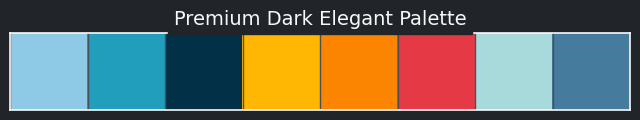

In [2]:

# Define a premium dark elegant color palette
dark_elegant_palette = [
    "#8ecae6",  # Light Blue Accent
    "#219ebc",  # Medium Blue
    "#023047",  # Deep Navy
    "#ffb703",  # Warm Yellow
    "#fb8500",  # Warm Orange
    "#e63946",  # Muted Red
    "#a8dadc",  # Soft Mint
    "#457b9d",  # Slate Blue
]

# Set a dark theme for Seaborn
sns.set_theme(
    style="darkgrid",              # Dark grid background
    palette=dark_elegant_palette,  # Custom color palette
    font="DejaVu Sans",
    rc={
        "axes.facecolor": "#212529",     # Dark background for axes
        "figure.facecolor": "#212529",   # Dark background for figure
        "axes.edgecolor": "#f8f9fa",     # Light axis lines
        "axes.labelcolor": "#f8f9fa",    # Light axis labels
        "text.color": "#f8f9fa",         # Light text
        "xtick.color": "#f8f9fa",        # Light tick labels
        "ytick.color": "#f8f9fa",
        "grid.color": "#495057",         # Muted gridlines
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.figsize": (8, 5),
        "axes.linewidth": 1.2,
    }
)

# Apply the palette to Matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=dark_elegant_palette)

# Preview the palette
sns.palplot(dark_elegant_palette)
plt.title("Premium Dark Elegant Palette", fontsize=14, color="#f8f9fa", backgroundcolor="#212529")
plt.show()


In [3]:
data_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'

In [4]:
print(f"Number of class: {len(os.listdir(data_path))}")

Number of class: 10


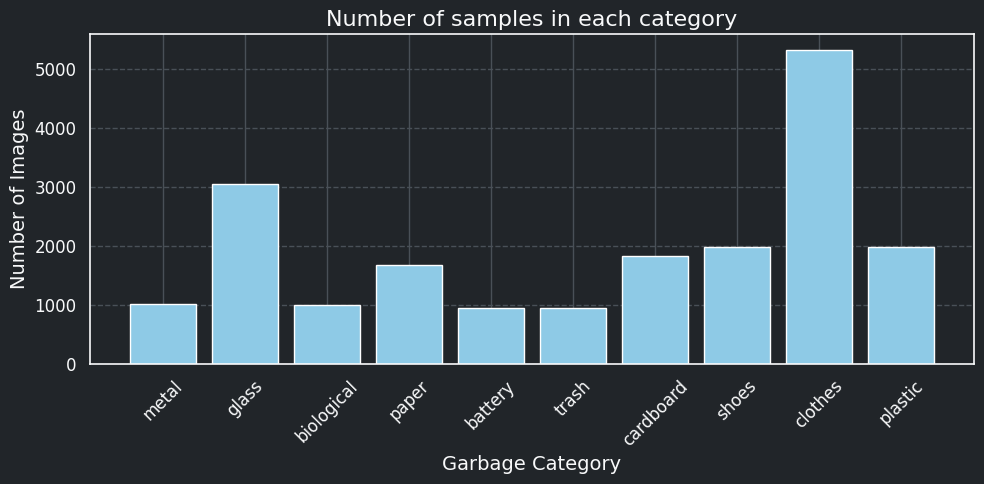

In [5]:
class_counts = { category: len(os.listdir(os.path.join(data_path, category))) for category in os.listdir(data_path) }

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Number of samples in each category")
plt.xlabel("Garbage Category")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()

In [6]:
def plot_samples(path_of_dataset):
    classes = os.listdir(path_of_dataset)
    random_imgs = []
    for clas in classes:
        class_path = os.path.join(path_of_dataset, clas)
        random_img = random.choice(os.listdir(class_path))  
        image_path = os.path.join(class_path, random_img)
        random_imgs.append(image_path)

    plt.figure(figsize=(20, 15))  
    for i, image_path in enumerate(random_imgs):
        plt.subplot(2, 5, i+1) 
        img = imread(image_path)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(image_path)))  
        plt.axis('off') 
    
    plt.tight_layout()  
    plt.show()


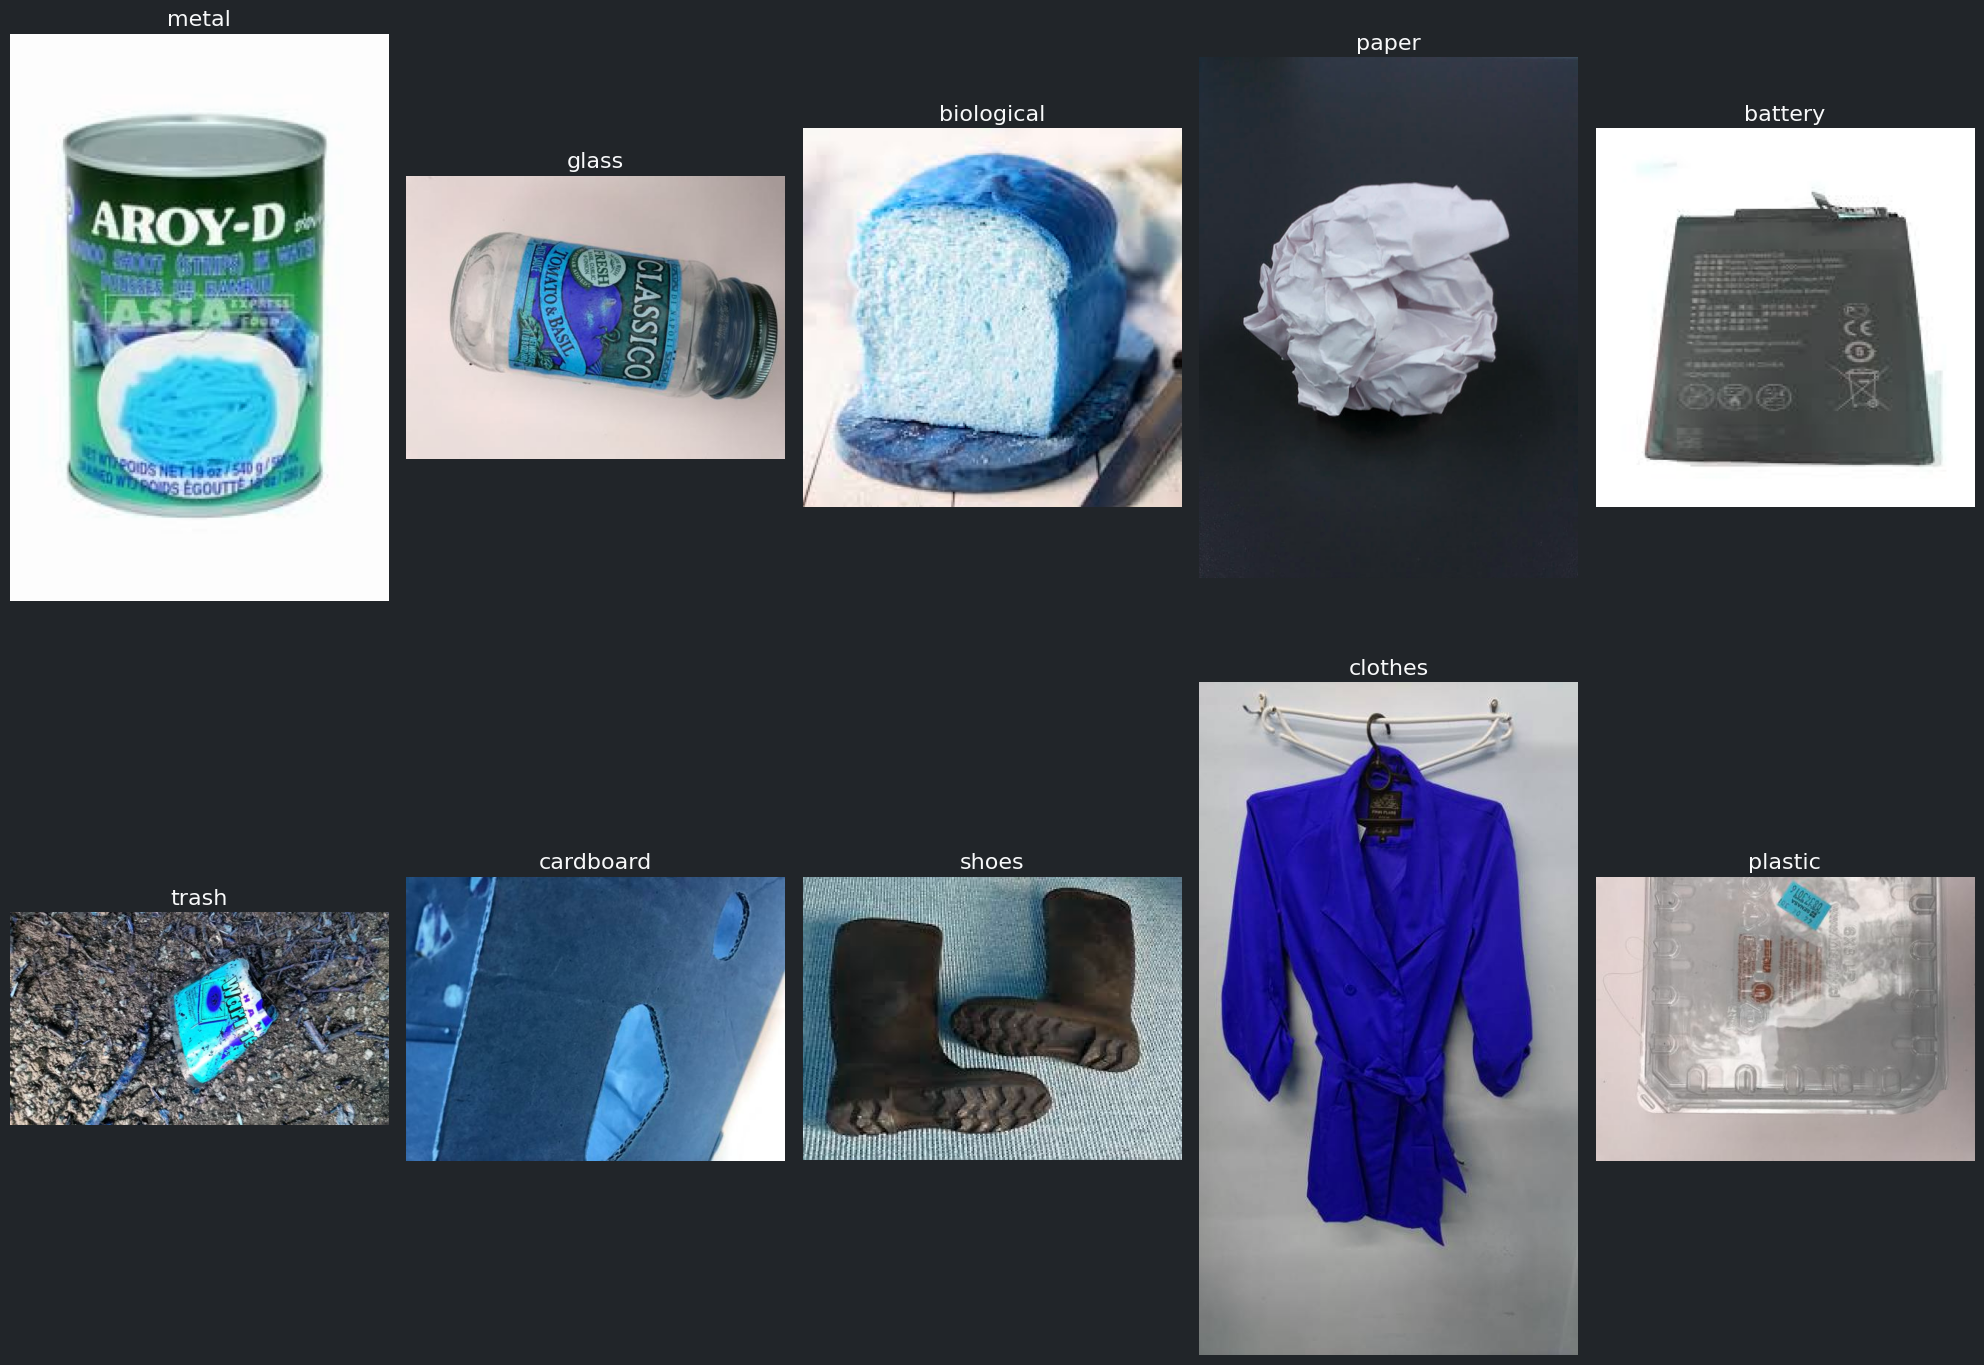

In [7]:
plot_samples(data_path)

In [8]:
def check_bad_images(base_path):
    bad_images = []
    
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                try:
                    img = Image.open(os.path.join(root, file))
                    img.verify()  # Will raise an exception if the image is corrupted
                except:
                    bad_images.append(os.path.join(root, file))
    
    print("Bad images:", bad_images)

In [9]:
check_bad_images(data_path)

Bad images: []


In [10]:
def get_shapes(base_path):
    image_shapes = []
    
    for clas in os.listdir(base_path):
        class_path = os.path.join(base_path, clas)
        for img_file in os.listdir(class_path)[:50]: 
            img_path = os.path.join(class_path, img_file)
            with Image.open(img_path) as img:
                image_shapes.append(img.size)
    
    # Convert to numpy array for statistics
    widths, heights = zip(*image_shapes)
    
    print(f"Average image width: {np.mean(widths):.2f}, height: {np.mean(heights):.2f}")
    print(f"Min size: {np.min(widths)}x{np.min(heights)} | Max size: {np.max(widths)}x{np.max(heights)}")

In [11]:
get_shapes(data_path)

Average image width: 379.55, height: 351.19
Min size: 144x109 | Max size: 2000x3556


In [12]:
target_size = (224, 224)
batch_size=32
seed=42

In [13]:

def create_datasets(data_path, target_size=(224, 224), batch_size=32, seed=42):
    """
    Creates train/val/test datasets 
    Returns: (train_gen, val_gen, test_gen, class_names)
    """
    # Get all image paths and labels
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_path, class_name)
        for img_file in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_name)  # Using string labels for flow_from_dataframe
    
    # Create dataframe
    df = pd.DataFrame({'filename': image_paths, 'class': labels})
    
    # Split into train (70%), val (20%), test (10%)
    train_df, temp_df = train_test_split(
        df, 
        test_size=0.3, 
        random_state=seed,
        stratify=df['class']
    )
    
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.333,  # 0.333 * 0.3 = 0.1 (10%)
        random_state=seed,
        stratify=temp_df['class']
    )
    
    # Create generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    # Flow from dataframe
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
    )
    
    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_gen = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen, class_names



In [15]:
train, validation, test, class_names = create_datasets(data_path)


Found 13833 validated image filenames belonging to 10 classes.
Found 3954 validated image filenames belonging to 10 classes.
Found 1975 validated image filenames belonging to 10 classes.


In [46]:

def build_garbage_classifier(input_shape=(224, 224, 3), num_classes=10):
    """
    Builds a custom CNN model for garbage classification.
    """
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    
    
    return model


In [47]:
model = build_garbage_classifier(input_shape=(224, 224, 3), num_classes=10)

In [48]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,982,762 (99.12 MB)

 Trainable params: 25,981,354 (99.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

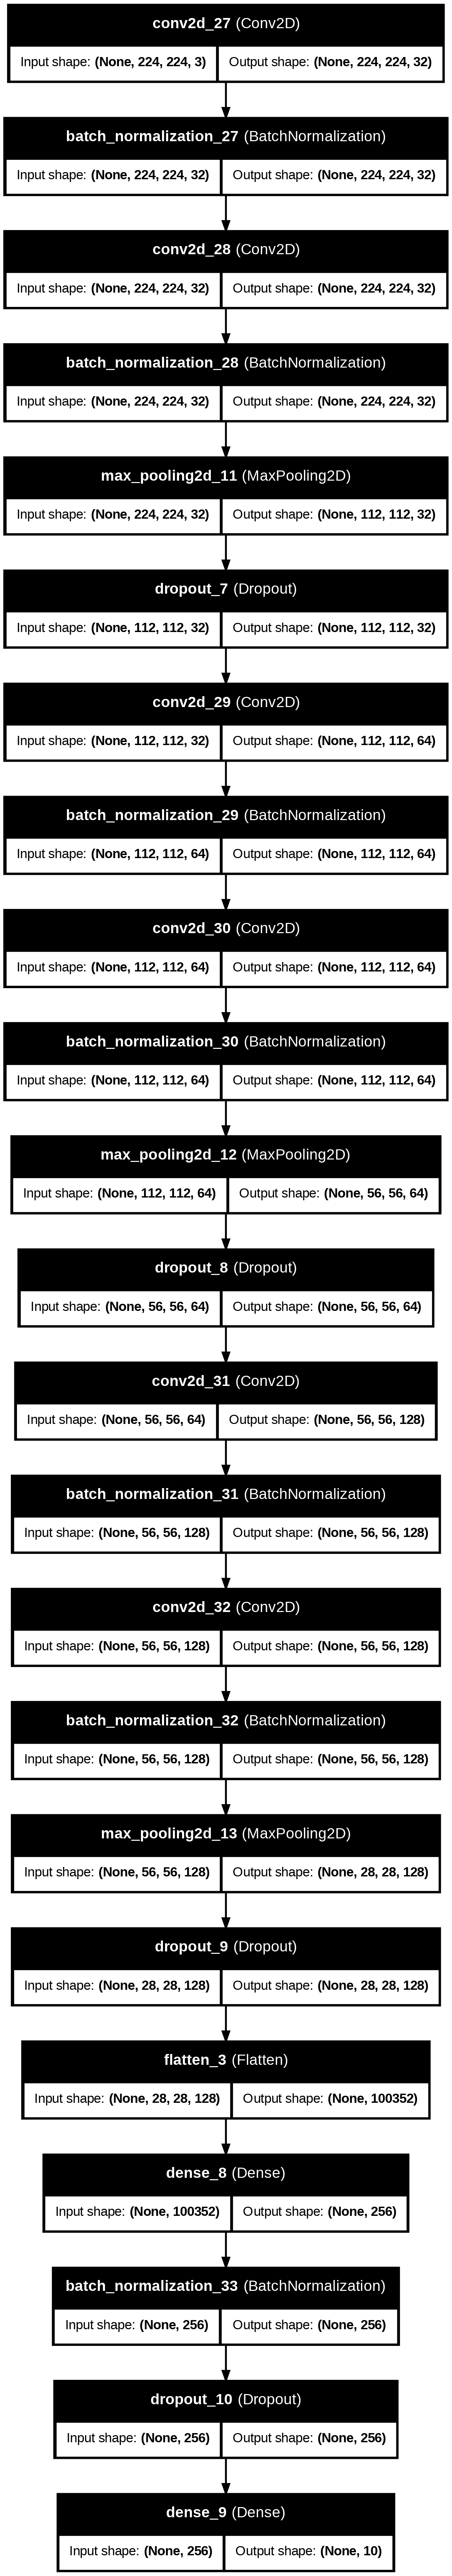

In [49]:
plot_model(
    model,
    to_file='model1.png',    
    show_shapes=True,    
    show_layer_names=True
)

In [51]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Track accuracy
    patience=6,
    mode='max'  # Stop when accuracy stops increasing
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [63]:
history = model.fit(
    train,
    validation_data=validation,
    epochs=40,
    callbacks=[
        early_stopping,
        reduce_lr
    ]
)


Epoch 1/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 206s 474ms/step - accuracy: 0.5024 - loss: 1.4715 - val_accuracy: 0.4863 - val_loss: 1.7965 - learning_rate: 0.0010
Epoch 2/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 207s 477ms/step - accuracy: 0.5389 - loss: 1.3385 - val_accuracy: 0.5169 - val_loss: 1.4909 - learning_rate: 0.0010
Epoch 3/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 207s 479ms/step - accuracy: 0.5693 - loss: 1.2614 - val_accuracy: 0.5384 - val_loss: 1.3924 - learning_rate: 0.0010
Epoch 4/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 205s 474ms/step - accuracy: 0.5982 - loss: 1.1954 - val_accuracy: 0.5225 - val_loss: 1.4582 - learning_rate: 0.0010
Epoch 5/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 204s 471ms/step - accuracy: 0.6125 - loss: 1.1346 - val_accuracy: 0.5030 - val_loss: 1.6517 - learning_rate: 0.0010
Epoch 6/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 205s 474ms/step - accuracy: 0.6300 - loss: 1.1001 - val_accuracy: 0.6125 - val_loss: 1.1677 - learning_rate: 0.0010
Epoch 7/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 204s 471ms/step - accura

In [64]:
test_loss, test_acc = model.evaluate(test, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.8674 - loss: 0.4464
Test Accuracy: 86.08%
Test Loss: 0.4491


In [65]:
def plot_training_curves(history):
    """
    Plots training & validation loss and accuracy.
    """
    # Extract data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Create plots
    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("training_curves.png")
    print("✅ Training curves saved as training_curves.png")
    plt.show()

# Call function


✅ Training curves saved as training_curves.png


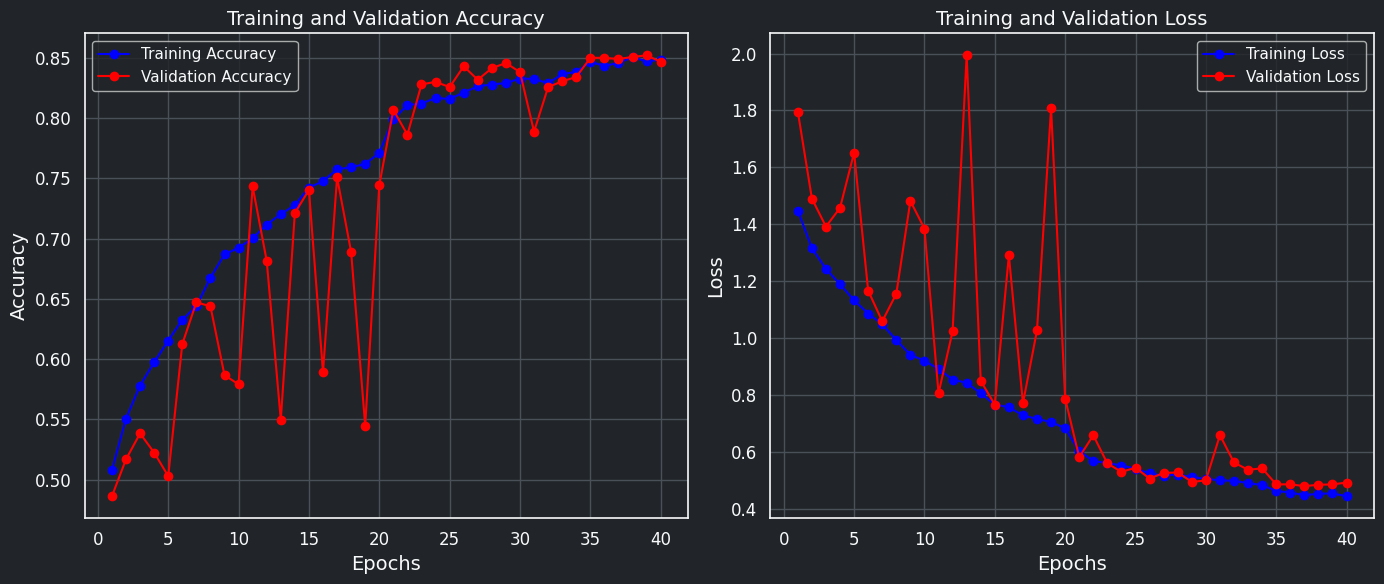

In [66]:
plot_training_curves(history)

In [67]:

def evaluate_model(model, test_gen, class_labels, save_prefix="model"):
    """
    Evaluates the model on a test set and saves evaluation artifacts.
    
    Args:
        model: Trained Keras model
        test_gen: Test data generator
        class_labels: List of class names
        save_prefix: Prefix for saved files (default 'model')
    """
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
    print(f"✅ Test Loss: {test_loss:.4f}")

    # Predict
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("\n📄 Classification Report:\n")
    print(report)

    # Save classification report
    report_file = f"{save_prefix}_classification_report.txt"
    with open(report_file, "w") as f:
        f.write(report)
    print(f"✅ Classification report saved to {report_file}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()

    cm_file = f"{save_prefix}_confusion_matrix.png"
    plt.savefig(cm_file)
    print(f"✅ Confusion matrix saved to {cm_file}")
    plt.show()


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.8674 - loss: 0.4464
✅ Test Accuracy: 86.08%
✅ Test Loss: 0.4491
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step

📄 Classification Report:

              precision    recall  f1-score   support

     battery       0.94      0.79      0.86        94
  biological       0.92      0.87      0.89       100
   cardboard       0.87      0.87      0.87       183
     clothes       0.93      0.96      0.95       532
       glass       0.87      0.85      0.86       306
       metal       0.74      0.66      0.69       102
       paper       0.81      0.90      0.86       168
     plastic       0.80      0.79      0.80       198
       shoes       0.79      0.79      0.79       197
       trash       0.77      0.79      0.78        95

    accuracy                           0.86      1975
   macro avg       0.84      0.83      0.83      1975
weighted avg       0.86      0.86      0.86      1975

✅ Classification report saved to garbage_classifier_clas

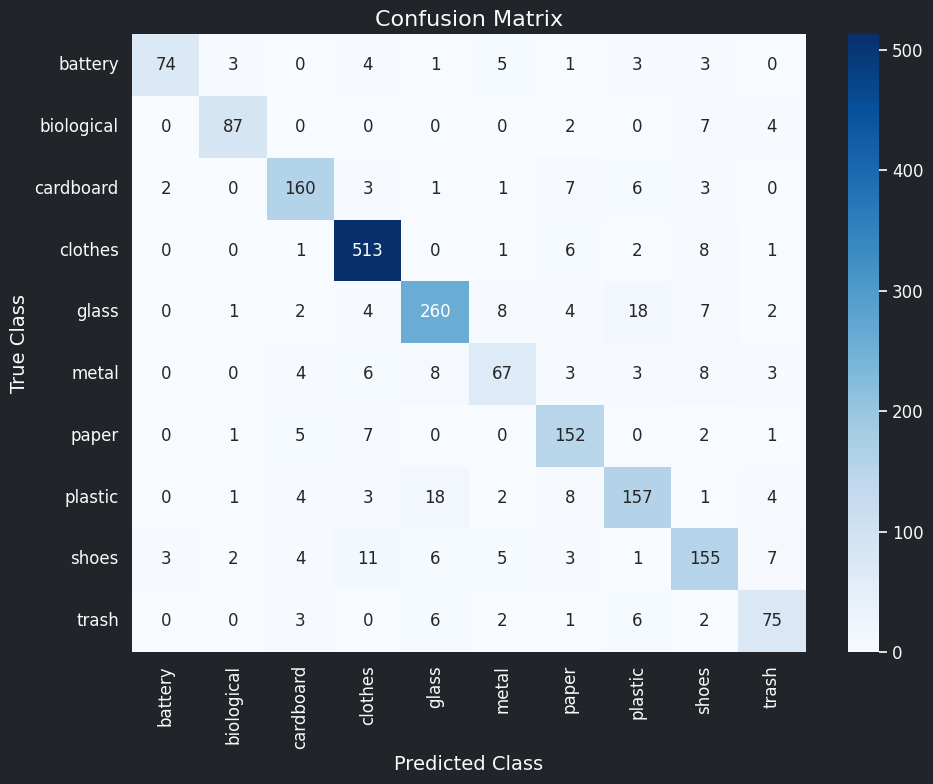

In [68]:
evaluate_model(model, test, class_names, save_prefix="garbage_classifier")

In [72]:
model.save("garbage_classifier_model.keras")
print("✅ Model saved as garbage_classifier_model.keras")

✅ Model saved as garbage_classifier_model.keras


In [70]:
with open("model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))
print("✅ Model summary saved to model_summary.txt")

✅ Model summary saved to model_summary.txt


In [71]:
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
print("✅ Training history saved to training_history.pkl")

✅ Training history saved to training_history.pkl
